In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from tqdm import tqdm

# Paths
speech_dir = 'Audio_Speech_Actors_01-24'
song_dir = 'Audio_Song_Actors_01-24'


In [2]:
#map the files according to the labbeled emotion
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def parse_filename(file_path, modality):
    file_name = os.path.basename(file_path)
    parts = file_name.split('.')[0].split('-')
    
    return {
        'filename': file_name,
        'emotion_code': parts[2],
        'emotion': emotion_map.get(parts[2], 'unknown'),
        'intensity': 'normal' if parts[3] == '01' else 'strong',
        'actor': int(parts[-1]),
        'modality': modality,
        'path': file_path
    }


In [3]:
def collect_files(directory, modality):
    all_entries = []
    for actor_dir in os.listdir(directory):
        actor_path = os.path.join(directory, actor_dir)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(actor_path, file)
                    entry = parse_filename(file_path, modality)
                    all_entries.append(entry)
    return all_entries

# Collect
speech_data = collect_files(speech_dir, 'speech')
song_data = collect_files(song_dir, 'song')

# Combine
df = pd.DataFrame(speech_data + song_data)
df.head()


,filename,emotion_code,emotion,intensity,actor,modality,path
0,03-01-01-01-01-01-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
1,03-01-01-01-01-02-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
2,03-01-01-01-02-01-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
3,03-01-01-01-02-02-01.wav,01,neutral,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...
4,03-01-02-01-01-01-01.wav,02,calm,normal,1,speech,Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...


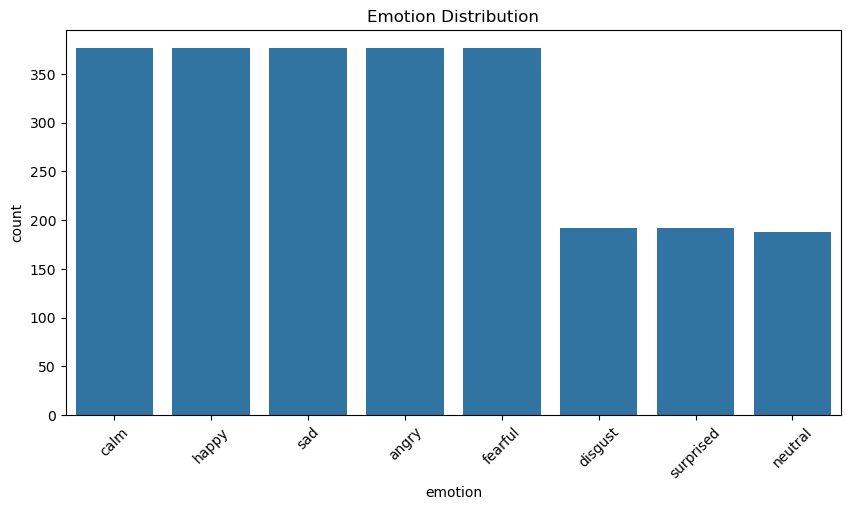

In [4]:
#emotion count distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()


* Emotions calm, happy, sad, angry, and fearful are equally represented.

* Emotions like disgust, surprised, and neutral appear less frequently.

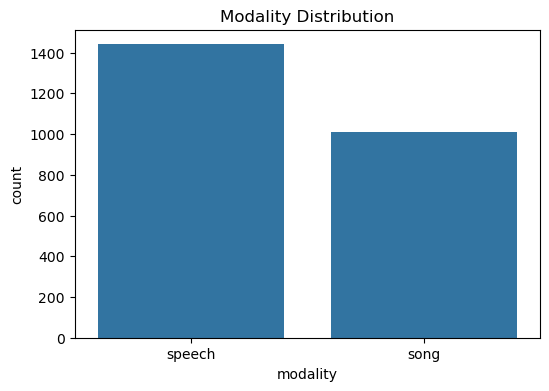

In [5]:
#data existence form
plt.figure(figsize=(6, 4))
sns.countplot(x='modality', data=df)
plt.title("Modality Distribution")
plt.show()


* More files in speech (around 1450) than song (around 1020).

* Reflects Actor 18 missing song data.

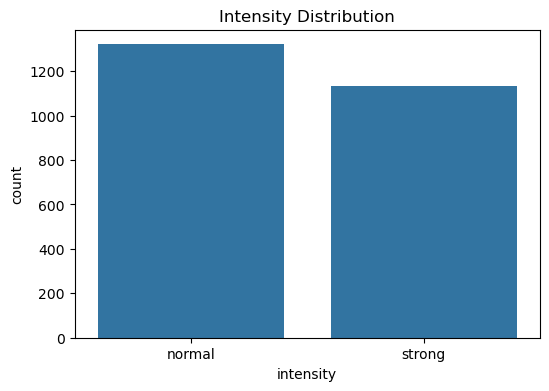

In [6]:
#intensity
plt.figure(figsize=(6, 4))
sns.countplot(x='intensity', data=df)
plt.title("Intensity Distribution")
plt.show()


* normal intensity is slightly more than strong.

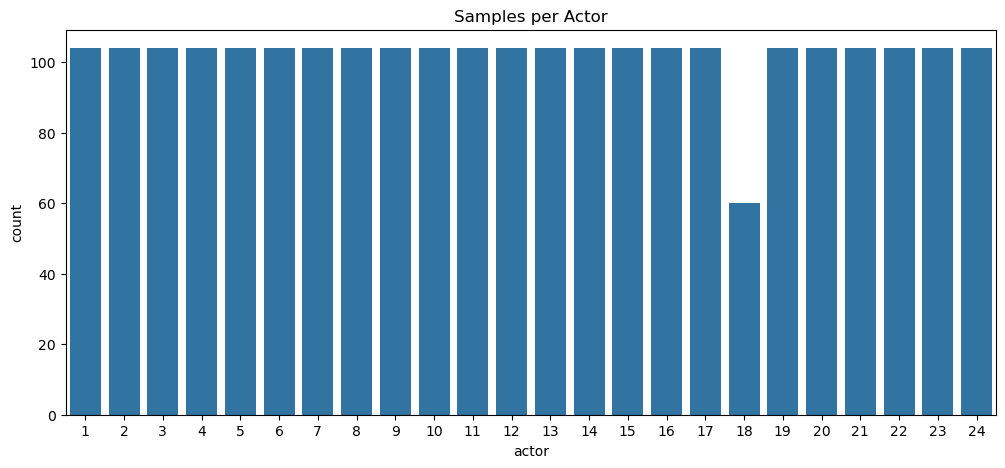

In [7]:
#actors and their sample counts
plt.figure(figsize=(12, 5))
sns.countplot(x='actor', data=df)
plt.title("Samples per Actor")
plt.show()


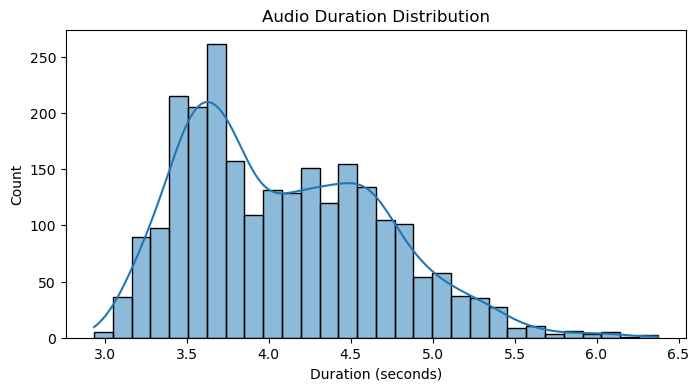

In [8]:
# audio duration analysis
def get_duration(row):
    try:
        y, sr = librosa.load(row['path'], sr=None)
        return librosa.get_duration(y=y, sr=sr)
    except:
        return None

df['duration'] = df.apply(get_duration, axis=1)

plt.figure(figsize=(8, 4))
sns.histplot(df['duration'].dropna(), bins=30, kde=True)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.show()


* Most audio clips are between 3.5 to 4.5 seconds.

* Very few go above 6 seconds.

In [9]:
# Check for nulls
print("Null values:\n", df.isnull().sum())

# Drop rows with any null values (if needed)
df = df.dropna()

# Check for duplicates
print("\nDuplicates:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()


Null values:
 filename        0
emotion_code    0
emotion         0
intensity       0
actor           0
modality        0
path            0
duration        0
dtype: int64

Duplicates: 0


In [10]:
#save the data frame ( for further use if needed )
df.to_csv('ravdess_metadata.csv', index=False)


In [11]:
#convert each audiofile to an image spectogram ( melspectogram )

# Output directory
output_dir = 'mel_spectrograms'
os.makedirs(output_dir, exist_ok=True)

#converter function
def audio_to_mel_image(audio_path, output_path, duration=4, sr=22050, img_size=(224, 224)):
    try:
        y, _ = librosa.load(audio_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            padding = sr * duration - len(y)
            y = np.pad(y, (0, int(padding)))

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Save mel spectrogram as image
        fig = plt.figure(figsize=(img_size[0] / 100, img_size[1] / 100), dpi=100)
        plt.axis('off')
        librosa.display.specshow(mel_db, sr=sr, cmap='viridis')
        fig.tight_layout(pad=0)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")


In [12]:
# Process each file

for _, row in tqdm(df.iterrows(), total=len(df)):
    emotion = row['emotion']
    audio_path = row['path']
    filename = os.path.splitext(os.path.basename(audio_path))[0] + ".png"
    emotion_dir = os.path.join(output_dir, emotion)
    os.makedirs(emotion_dir, exist_ok=True)
    output_path = os.path.join(emotion_dir, filename)

    audio_to_mel_image(audio_path, output_path)
print("successful")

100%|██████████| 2452/2452 [01:25<00:00, 28.64it/s]

successful


In [13]:
#Confirm GPU is Enabled in PyTorch
import torch
print(torch.version.cuda)             
print(torch.cuda.is_available())      
print(torch.cuda.get_device_name(0))   

11.8
True
NVIDIA GeForce RTX 4060


In [15]:
# Imports
import os
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image


In [16]:
# Parameters
BATCH_SIZE = 16
NUM_EPOCHS = 40
IMAGE_SIZE = 300  # For EfficientNet-B3
DATA_DIR = 'mel_spectrograms'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [17]:
# Load Dataset (force RGB)
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
dataset.loader = lambda path: Image.open(path).convert("RGB")
NUM_CLASSES = len(dataset.classes)

# Train/Val Split (Stratified optional)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


In [18]:

# Compute Class Weights
targets = [dataset.targets[i] for i in train_ds.indices]
weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(DEVICE)


In [19]:
# Load EfficientNet-B3
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)


In [20]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [21]:

# Train
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / len(val_ds)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f}  "
          f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")

Epoch [1/40] Train Loss: 2.0558  Val Loss: 1.9365  Val Acc: 0.2974
Epoch [2/40] Train Loss: 1.8359  Val Loss: 1.6508  Val Acc: 0.4053
Epoch [3/40] Train Loss: 1.5831  Val Loss: 1.4051  Val Acc: 0.5071
Epoch [4/40] Train Loss: 1.4026  Val Loss: 1.2706  Val Acc: 0.5519
Epoch [5/40] Train Loss: 1.2863  Val Loss: 1.2010  Val Acc: 0.5927
Epoch [6/40] Train Loss: 1.1796  Val Loss: 1.1346  Val Acc: 0.6151
Epoch [7/40] Train Loss: 1.0838  Val Loss: 1.0783  Val Acc: 0.6517
Epoch [8/40] Train Loss: 1.0287  Val Loss: 1.0461  Val Acc: 0.6558
Epoch [9/40] Train Loss: 0.9875  Val Loss: 0.9803  Val Acc: 0.6843
Epoch [10/40] Train Loss: 0.9354  Val Loss: 0.9811  Val Acc: 0.6782
Epoch [11/40] Train Loss: 0.8719  Val Loss: 0.9536  Val Acc: 0.7006
Epoch [12/40] Train Loss: 0.8162  Val Loss: 0.9241  Val Acc: 0.6945
Epoch [13/40] Train Loss: 0.7746  Val Loss: 0.9641  Val Acc: 0.7047
Epoch [14/40] Train Loss: 0.7548  Val Loss: 0.9291  Val Acc: 0.7230
Epoch [15/40] Train Loss: 0.7005  Val Loss: 0.9096  Val A

In [22]:
# Final Evaluation Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))



--- Classification Report ---
              precision    recall  f1-score   support

       angry       0.87      0.89      0.88        76
        calm       0.84      0.90      0.87        68
     disgust       0.78      0.81      0.79        36
     fearful       0.75      0.77      0.76        77
       happy       0.85      0.85      0.85        80
     neutral       0.80      0.68      0.74        41
         sad       0.66      0.59      0.62        71
   surprised       0.91      0.98      0.94        42

    accuracy                           0.81       491
   macro avg       0.81      0.81      0.81       491
weighted avg       0.80      0.81      0.80       491



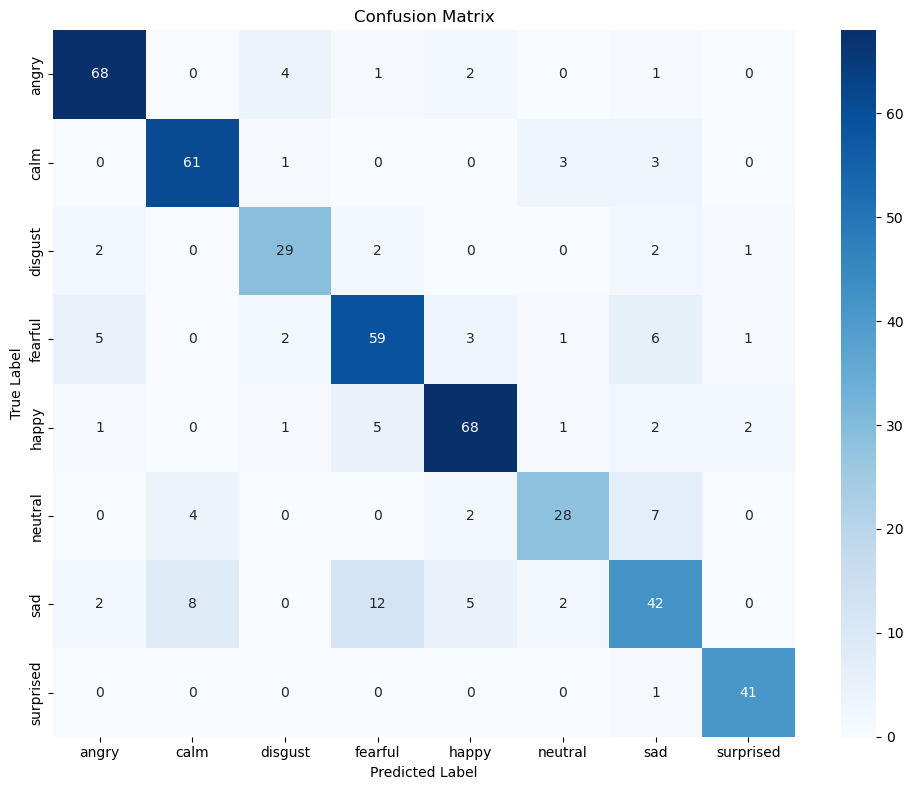

In [23]:

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [24]:
# Save the trained EfficientNet-B3 model
MODEL_PATH = "emotion_b3_model.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved successfully at: {MODEL_PATH}")


✅ Model saved successfully at: emotion_b3_model.pth
